In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
import random
torch.set_default_tensor_type('torch.cuda.FloatTensor')
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
from sklearn.model_selection import KFold

#then import my own modules
# from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight
from timeit import default_timer as timer
from AttentiveFP import Fingerprint, Fingerprint_viz, graph_dict, graph_dataset, null_collate, Graph, Logger, time_to_str


In [2]:
cuda_aviable = torch.cuda.is_available()
device = torch.device(0)

SEED = 8
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic=True


In [3]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer

number of all smiles:  4200
number of successfully processed smiles:  4200


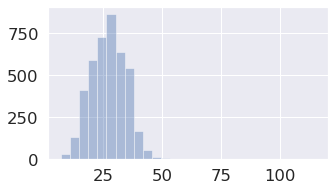

In [4]:
task_name = 'lipophilicity'
tasks = ['exp']

raw_filename = "../data/Lipophilicity.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))

smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)].reset_index()
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
plt.show()
plt.close()


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

epochs = 80
batch_size =100

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 3
K = 2
T = 4
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smiles_list = smiles_tasks_df['smiles'].values
label_list = smiles_tasks_df[tasks[0]].values
graph_dict = graph_dict(smiles_list, label_list, filename)


graph dicts loaded from ../data/Lipophilicity.pkl


In [7]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
train_fold = []
valid_fold = []
for k, (train_idx, valid_idx) in enumerate(kfold.split(smiles_list)):
    train_fold.append(train_idx)
    valid_fold.append(valid_idx)
    
# avoiding the last batch has too few samples by slightly tune the batch_size
while (len(train_fold[0]) % batch_size) / batch_size <0.8:
    batch_size +=1
print("batch size: ", batch_size)

batch size:  102


In [8]:
loss_function = nn.MSELoss()
model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
model.to(device)

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in  model.parameters()])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

1604858
atom_preprocess.preprocess.0.linear.weight torch.Size([200, 39])
atom_preprocess.preprocess.0.linear.bias torch.Size([200])
atom_preprocess.preprocess.0.bn.weight torch.Size([200])
atom_preprocess.preprocess.0.bn.bias torch.Size([200])
atom_preprocess.preprocess.3.linear.weight torch.Size([200, 200])
atom_preprocess.preprocess.3.linear.bias torch.Size([200])
atom_preprocess.preprocess.3.bn.weight torch.Size([200])
atom_preprocess.preprocess.3.bn.bias torch.Size([200])
bond_preprocess.preprocess.0.linear.weight torch.Size([200, 10])
bond_preprocess.preprocess.0.linear.bias torch.Size([200])
bond_preprocess.preprocess.0.bn.weight torch.Size([200])
bond_preprocess.preprocess.0.bn.bias torch.Size([200])
bond_preprocess.preprocess.3.linear.weight torch.Size([200, 200])
bond_preprocess.preprocess.3.linear.bias torch.Size([200])
bond_preprocess.preprocess.3.bn.weight torch.Size([200])
bond_preprocess.preprocess.3.bn.bias torch.Size([200])
align.linear.weight torch.Size([1, 800])
align

In [9]:
def train(smiles_list):
    model.train()
    train_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=True, worker_init_fn=np.random.seed(SEED))
    losses = []
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(train_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        
        loss = loss_function(mol_prediction, label.view(-1,1))     
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())

    return np.mean(losses)

        
def eval(smiles_list):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    eval_loader = DataLoader(graph_dataset(smiles_list, graph_dict), batch_size, collate_fn=null_collate, \
                              num_workers=8, pin_memory=True, shuffle=False, worker_init_fn=np.random.seed(SEED))
    for b, (smiles, atom, bond, bond_index, mol_index, label) in enumerate(eval_loader):
        atom = atom.to(device)
        bond = bond.to(device)
        bond_index = bond_index.to(device)
        mol_index = mol_index.to(device)
        label = label.to(device)
        
        mol_prediction = model(atom, bond, bond_index, mol_index)
        MAE = F.l1_loss(mol_prediction, label.view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, label.view(-1,1), reduction='none')
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.sqrt(np.array(eval_MAE_list).mean()), np.sqrt(np.array(eval_MSE_list).mean())


In [10]:
# log = Logger()
# log.open(f'{prefix_filename}_{start_time}.txt')

# f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
# log.write('epoch | loss | train MSE |  valid MSE |  time \n')
# start = timer()

# best_param ={}
# best_param["train_epoch"] = 0
# best_param["valid_epoch"] = 0
# best_param["train_MSE"] = 9e8
# best_param["valid_MSE"] = 9e8

# fold_index = 3
# for epoch in range(800):
#     losses = train(smiles_list[train_fold[fold_index]])
#     traine_MAE, train_MSE = eval(smiles_list[train_fold[fold_index]])
#     valid_MAE, valid_MSE = eval(smiles_list[valid_fold[fold_index]])

#     timing = time_to_str((timer() - start), 'min')  
#     log.write(f.format(epoch, losses, train_MSE, valid_MSE, timing))

#     if train_MSE < best_param["train_MSE"]:
#         best_param["train_epoch"] = epoch
#         best_param["train_MSE"] = train_MSE
#     if valid_MSE < best_param["valid_MSE"]:
#         best_param["valid_epoch"] = epoch
#         best_param["valid_MSE"] = valid_MSE
# #         if valid_MSE < 0.35:
# #              torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
#     if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
#         break
# print(best_param["valid_epoch"],best_param["train_MSE"],best_param["valid_MSE"])

In [11]:

log = Logger()
log.open(f'log/{prefix_filename}_{start_time}.txt')

f = '{:^5} | {:^7.4f} | {:^7.4f} | {:^7.4f} | {:^7} \n'
log.write('epoch | loss | train RMSE |  valid RMSE |  time \n')
start = timer()

log2 = Logger()
log2.open(f'{prefix_filename}_best_{start_time}.txt')
f2 = '{:^5} | {:^5} | {:^7.4f} | {:^7.4f} \n'

for fold_index in range(5):
    
    model = Fingerprint(output_units_num, fingerprint_dim, K=K, T=T, p_dropout=p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
    
    best_param ={}
    best_param["train_epoch"] = 0
    best_param["valid_epoch"] = 0
    best_param["train_RMSE"] = 800
    best_param["valid_RMSE"] = 800
    for epoch in range(800):
        losses = train(smiles_list[train_fold[fold_index]])
        traine_MAE, train_RMSE = eval(smiles_list[train_fold[fold_index]])
        valid_MAE, valid_RMSE = eval(smiles_list[valid_fold[fold_index]])
        
        timing = time_to_str((timer() - start), 'min')  
        log.write(f.format(epoch, losses, train_RMSE, valid_RMSE, timing))
        
        if train_RMSE < best_param["train_RMSE"]:
            best_param["train_epoch"] = epoch
            best_param["train_RMSE"] = train_RMSE
        if valid_RMSE < best_param["valid_RMSE"]:
            best_param["valid_epoch"] = epoch
            best_param["valid_RMSE"] = valid_RMSE
#             if valid_RMSE < 0.35:
#                  torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
        if (epoch - best_param["train_epoch"] >10) and (epoch - best_param["valid_epoch"] >18):        
            break

    log2.write('fold | epoch | train RMSE | valid RMSE \n')
    log2.write(f2.format(fold_index, best_param["valid_epoch"],best_param["train_RMSE"],best_param["valid_RMSE"]))
    
    

epoch | loss | train RMSE |  valid RMSE |  time 
  0   | 2.6058  | 1.7730  | 1.6453  |  0 hr 00 min 
  1   | 1.0792  | 0.8899  | 0.8524  |  0 hr 00 min 
  2   | 0.8072  | 0.8179  | 0.8325  |  0 hr 00 min 
  3   | 0.6952  | 0.7946  | 0.7762  |  0 hr 00 min 
  4   | 0.5942  | 0.6932  | 0.7691  |  0 hr 00 min 
  5   | 0.5388  | 0.6690  | 0.7095  |  0 hr 00 min 
  6   | 0.5186  | 0.6309  | 0.6877  |  0 hr 00 min 
  7   | 0.4589  | 0.8271  | 0.8647  |  0 hr 00 min 
  8   | 0.4250  | 0.6813  | 0.7917  |  0 hr 00 min 
  9   | 0.4054  | 0.5658  | 0.6770  |  0 hr 00 min 
 10   | 0.3740  | 0.6078  | 0.7043  |  0 hr 00 min 
 11   | 0.3633  | 0.5243  | 0.6548  |  0 hr 00 min 
 12   | 0.3321  | 0.4690  | 0.6359  |  0 hr 00 min 
 13   | 0.3208  | 0.5084  | 0.6373  |  0 hr 00 min 
 14   | 0.2858  | 0.4931  | 0.6743  |  0 hr 01 min 
 15   | 0.2875  | 0.5020  | 0.6990  |  0 hr 01 min 
 16   | 0.2597  | 0.4018  | 0.6155  |  0 hr 01 min 
 17   | 0.2470  | 0.4115  | 0.6187  |  0 hr 01 min 
 18   | 0.2314 

 38   | 0.1004  | 0.2166  | 0.6407  |  0 hr 11 min 
 39   | 0.1017  | 0.2357  | 0.6249  |  0 hr 11 min 
 40   | 0.1027  | 0.2304  | 0.6366  |  0 hr 12 min 
 41   | 0.1067  | 0.2307  | 0.6282  |  0 hr 12 min 
 42   | 0.0935  | 0.2408  | 0.6402  |  0 hr 12 min 
 43   | 0.0963  | 0.2253  | 0.6423  |  0 hr 12 min 
 44   | 0.0836  | 0.2173  | 0.6317  |  0 hr 12 min 
 45   | 0.0857  | 0.1972  | 0.6147  |  0 hr 12 min 
 46   | 0.0935  | 0.2115  | 0.6365  |  0 hr 12 min 
 47   | 0.0980  | 0.2352  | 0.6449  |  0 hr 12 min 
 48   | 0.0897  | 0.2183  | 0.6285  |  0 hr 13 min 
 49   | 0.0818  | 0.1948  | 0.6346  |  0 hr 13 min 
 50   | 0.0916  | 0.2077  | 0.6527  |  0 hr 13 min 
 51   | 0.0850  | 0.2087  | 0.6354  |  0 hr 13 min 
 52   | 0.0832  | 0.2247  | 0.6446  |  0 hr 13 min 
 53   | 0.0778  | 0.2011  | 0.6365  |  0 hr 13 min 
 54   | 0.0778  | 0.1999  | 0.6339  |  0 hr 13 min 
 55   | 0.0770  | 0.2239  | 0.6463  |  0 hr 13 min 
 56   | 0.0904  | 0.2020  | 0.6320  |  0 hr 14 min 
 57   | 0.06

 21   | 0.1906  | 0.3626  | 0.6930  |  0 hr 28 min 
 22   | 0.1809  | 0.3611  | 0.6801  |  0 hr 28 min 
 23   | 0.1844  | 0.3409  | 0.6865  |  0 hr 28 min 
 24   | 0.1578  | 0.3440  | 0.6871  |  0 hr 28 min 
 25   | 0.1572  | 0.3284  | 0.6767  |  0 hr 28 min 
 26   | 0.1461  | 0.3614  | 0.7054  |  0 hr 28 min 
 27   | 0.1452  | 0.3072  | 0.6729  |  0 hr 28 min 
 28   | 0.1656  | 0.3272  | 0.6929  |  0 hr 29 min 
 29   | 0.1449  | 0.2920  | 0.6769  |  0 hr 29 min 
 30   | 0.1341  | 0.3195  | 0.6837  |  0 hr 29 min 
 31   | 0.1402  | 0.3339  | 0.6927  |  0 hr 29 min 
 32   | 0.1304  | 0.2454  | 0.6624  |  0 hr 29 min 
 33   | 0.1153  | 0.2947  | 0.6859  |  0 hr 29 min 
 34   | 0.1134  | 0.2587  | 0.6758  |  0 hr 29 min 
 35   | 0.1236  | 0.2538  | 0.6725  |  0 hr 29 min 
 36   | 0.1076  | 0.2605  | 0.6909  |  0 hr 29 min 
 37   | 0.1027  | 0.2402  | 0.6785  |  0 hr 29 min 
 38   | 0.0993  | 0.2431  | 0.6682  |  0 hr 30 min 
 39   | 0.1164  | 0.2291  | 0.6519  |  0 hr 30 min 
 40   | 0.10

In [12]:
# # evaluate model
# best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()
# test_MAE, test_MSE = eval(model, test_df)
# print("best epoch:",best_param["test_epoch"],"\n","test MSE:",test_MSE)

In [13]:
# for e in range(20):
#     losses = train(smiles_list[valid_fold[fold_index]])
#     print(losses)